# Fine tuning BERT for information retrieval using Amazon Sagemaker 

## Runtime
This notebook takes approximately 30 minutes to run.



## Contents
   Background
1. Development environment and permissions
   - Installation
   - Permissions
2. Training
   - Downloading data 
   - Preparing the data
   - Bi-Encoder Transformer Neural Network
3. Inference
   - Offline scoring
   - Realtime endpoint
4. OpenSearch
   - OpenSearch Client
   - Index and mapping
   - Ingestion of documents
5. Simulated Semantic Search Application
   - Search Widget
   - Pipeline
   
### Terminology: sentence, document, passage : All of these terms mean the same, the response for a query   

## Background 

The Transformer deep learning architecture has proven very successful, and has spawned several state of the art model families. One among them is Bidirectional Encoder Representations from Transformers (BERT): 340 million parameters [1]

With transformers, the “pretrain then fine-tune” recipe has emerged as the standard approach of applying BERT to specific downstream tasks such as classification, sequence labeling, information retrieval and ranking. Typically, we start with a “base” pretrained transformer model such as the BERTBase and BERTLarge checkpoints directly downloadable from **SBERT** or the Hugging Face Transformers library. This model is then fine-tuned on task-specific labeled data drawn from the same distribution as the target task.

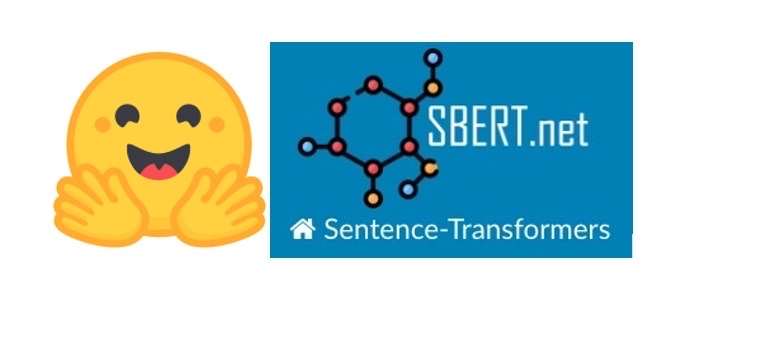

Information retrieval (search) systems use lexical search algoritms such as BM-25, TF-IDF to find answers matching to a query. When we are able to use pre-trained language models like BERT for search systems, we can achieve higher search relevance as the pre-trained models will help in finding **semantic matches** rather then just **term match** for a query. At the same time, one should consider fine-tuning the original BERT model before using it for specific downstream task like information retrieval which helps in curriculum learning. 

The SBERT framework which is based on PyTorch and Transformers, offers a large collection of pre-trained models tuned for various tasks. We will be focussing on fine tuning the BERT model on data retrieval (search) usecase.

In this notebook, we are attempting to fine-tune the BERT model for information retrieval usecase based on the original research paper Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks [2].

**References**

- [1] “BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding“, Jacob Devlin, Ming-Wei Chang, Kenton Lee, Kristina Toutanova.
- [2] Reimers, N., & Gurevych, I. (2019). Sentence-bert: Sentence embeddings using siamese bert-networks. arXiv preprint arXiv:1908.10084.

## 1. Development environment and permissions

Lets start with setting up the development environment and permissions, First we make sure that the kernel is set to "conda_amazonei_pytorch_latest_p36". Once the kernel is ready, we start with installing and importing all the required libraries.

### Install and import dependencies

In [ ]:
import subprocess
import sys

def install(package):
    subprocess.check_call([sys.executable, "-q", "-m", "pip", "install", package])
    
install('sentence_transformers')
install('opensearch-py')
install('requests_aws4auth')

import json
import requests
import boto3
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer, LoggingHandler, util, models, evaluation, losses, InputExample
import logging
from datetime import datetime
import gzip
import os
import tarfile
from collections import defaultdict
from torch.utils.data import IterableDataset
import tqdm
from torch.utils.data import Dataset
import random
import pickle
import argparse
import sagemaker
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role

### Setup the Sagemaker session, region and IAM role 

This notebook is already configured with an execution role which gives sagemaker, the permissions on behalf of us to access other services like S3, Sagemaker model training, sagemaker endpoints etc.

We have created a S3 bucket for this notebook to store all the model artifacts. In the following code, we save the execution role arn and s3 bucket name as variables to be used later. 

In [ ]:
role = get_execution_role()
account = role.split('::')[1].split(':')[0]
bucket = "sagemaker-nlp-"+account
boto3_session = boto3.session.Session()
my_region = boto3_session.region_name
output_path = "s3://"+bucket+"/nlp-dualencoder"
output_path

## 2. Training
For model training, we are using Sagemaker Pytorch framework and provide a custom training script (nlp_loader_test.py). This script does the following steps,  

### Downloading the data

We are using MS MARCO dataset (https://microsoft.github.io/msmarco/Datasets). This is a large dataset to train models for information retrieval. It consists of about 500k real search queries from Bing search engine with the relevant text passages in descending order of relevance that answers the query.

The dataset has 2 attributes,

<table style = "text-align:left">
    <tr align = 'left'>
        <th style = "text-align:left" > Attribute </th>
        <th style = "text-align:left" >Type</th>
        <th style = "text-align:left" >Description</th>
    </tr>
    <tr align = 'left'>
        <td style = "text-align:left"> Query </td>
        <td style = "text-align:left">Text</td>
        <td style = "text-align:left">The question asked in the search engine</td>
    </tr>
    <tr align = 'left'>
        <td style = "text-align:left"> Passage(s) </td>
        <td style = "text-align:left">Array of texts</td>
        <td style = "text-align:left">The responses that the user voted as relevant to the query they asked, these responses  are ordered in such a way that the highly relevant response comes first and the responses with poor/no relevance comes last</td>
    </tr>
</table>
    
The script, as the first step, downloads the dataset directly from the microsoft repository and stores in the training container.

note: we can replace this using s3 where we can get the data downloaded to s3 and source s3 everytime.

### Preparing the data

We take the original data in the above format and convert into triplets: ***(query, positive_response, negative_response)*** where positive_response is the highly relevant response to the query and negative_response is a non/less-relevant response to the query. We use more than one negative_response in order of relevancy to make the model learn to distinguish well between the postive and the negative responses for a search query.

A sample instance of the prapared dataset will look as follows,


{
   'query': 'what are the liberal arts?',

   'positive': 'liberal arts, the academic course of instruction at a college intended to provide general knowledge and comprising the arts, humanities, natural sciences, and social sciences, as opposed to professional or technical subjects.',

   'negative': 
   [

   1. 'A liberal arts college is a four-year institution that focuses on the study of liberal arts...'

   2. 'Liberal arts, college or university curriculum aimed at imparting general knowledge...',

   3. 'The liberal arts education at the secondary school level prepares the student for higher education at a university....',

   4. 'A liberal arts major offers a broad overview of the arts, sciences, and humanities...'

   ]
}


### Bi-Encoder Transformer Neural Network

For Information retrieval tasks (Searching), a Bi-encoder Transformer network can be used to fine tune the BERT embeddings, One encoder will represent the Query and the other will represent the actual positive/negative response. The fine tuning will be done to optimise the following objective: We want to have the ***(query, positive_response)*** pair to be close in the vector space, while ***(query, negative_response)*** should be distant in vector space. 

We can then use these fine-tuned embeddings to encode the responses and queries into vectors and retrieve most relevant documents for a query by computing the distance between the vectors. This way we can overcome the limitations of traditional lexical search.

***Bi-encoder Transformer network***

u - Query
v - Response
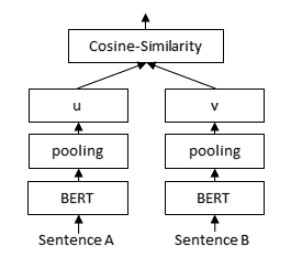

***Training Objective: Fine-tuned high dimensional space***

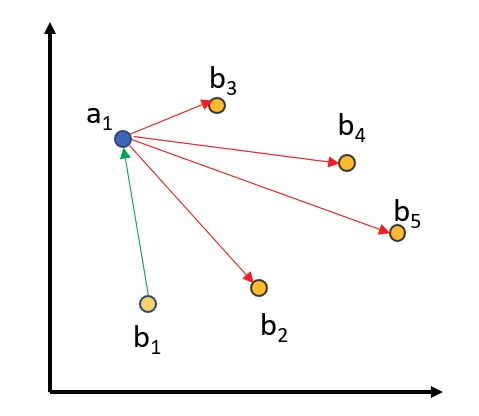

#### References: https://www.sbert.net/examples/training/ms_marco/README.html

***We will use one (non-gpu) instance_type ml.c5.4xlarge to train the Bi-Encoder network with the triplets. The original dataset has nearly 500k queries, for the sake of this workshop, we take 1000 queries with each having 1 positive and 4 negative responses to form the triplets and train the model. Please consider a offline training on the whole dataset for better accuracy***

The below code snippet calls the training script (nlp_loader_test.py) and run the 3 steps, 
- Data downloading
- Data Preparation
- **Creating a PyTorch estimator and starting the sagemaker training job** to train the Bi-Encoder transformer network

At the end of these 3 steps, the model gets saved to specified S3 location. As you run the below code, provided the training job ran successful, You should get many pages of output with final 4 lines similar to,

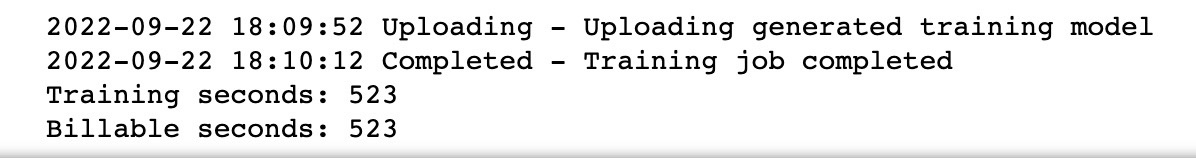

note: Set local_mode to True in the below code if you want to use the local machine for model training

In [ ]:
local_mode = False

if local_mode:
    instance_type = "local"
else:
    instance_type = "ml.c5.4xlarge"

est = PyTorch(
    entry_point="nlp_loader_test.py",
    source_dir="/home/ec2-user/SageMaker/amazon-sagemaker-bert-finetuning-for-search/scripts/code",  # directory of your training script
    role=role,
    framework_version="1.5.0",
    py_version="py3",
    instance_type=instance_type,
    instance_count=1,
    volume_size=250,
    output_path=output_path,
    hyperparameters={"sample_queries":1000, "batch-size": 64, "epochs": 1, "learning-rate": 1e-3}
)

est.fit() #Start the Training job

## 3.  Inference 

Having the model trained and the model artifacts stored in s3, We retrieve the latest trained model from s3 and create HuggingFace estimator object for Inference

We use a custom **inference Script (inference.py)** which does the following,

- Pre-processing of the data: tokenising the sentences using the BERT tokeniser
- Calling the fine-tuned BERT model to convert the sentences into BERT vectors. 

While running the below code, if you get a warning similar to **PythonDeprecationWarning: Boto3 will no longer support Python 3.6...**, Please ignore.  

In [ ]:
#Make sure you provide / in the end
prefix = 'nlp-dualencoder/' 
key_list=[]

s3_client = boto3.client('s3')
result = s3_client.list_objects(Bucket=bucket, Prefix=prefix, Delimiter='/')
for i in result.get('CommonPrefixes'):
    key_list.append(i.get('Prefix'))
    
key_list_sorted = sorted(key_list, reverse=True)
model_artifact_s3uri = 's3://'+bucket+'/'+key_list_sorted[0]+'output/model.tar.gz'
model_artifact_s3key = key_list_sorted[0]+'output/model.tar.gz'
model_artifact_s3key_prefix = key_list_sorted[0].split("/")[0]

from sagemaker.huggingface.model import HuggingFaceModel

# create Hugging Face Model Estimator
huggingface_model = HuggingFaceModel(
entry_point = 'inference.py',
    source_dir="/home/ec2-user/SageMaker/amazon-sagemaker-bert-finetuning-for-search/scripts/code",
   model_data=model_artifact_s3uri,       # path to your model and script
   role=role,                    # iam role with permissions to create an Endpoint
   transformers_version="4.17.0",  # transformers version used
   pytorch_version="1.10.2",        # pytorch version used
   py_version='py38',            # python version used
)

print('Inference Estimator is created')

### Offline Scoring

In real world semantic search, using a trained model to convert the documents and queries into vectors will involve higher latency as the model has to be triggered multiple times in realtime for an incoming search query and the stored documents. To avoid this, we can do the following steps,

1. Pre-transform all the documents/passages into vectors and store all the documents along with the vectors in a database or any datastore, 
2. Transform only the incoming query into vector in realtime, compare the incoming query vectors against the stored, pre-transformed document/passage vectors using any similarity metric.

This way, during a search activity, we are limiting the model triggering only once for the incoming query and thereby reduce the latency. In the below code, we copy the model artifacts to the local machine and pre-transform all the documents/passages into vectors using our fine-tuned model and store the transformed data in S3.

note: We can do this offline scoring using Sagemaker Batch Transform job too, for the sake of experiment, we are using the local machine, iterate only through the top 100 sentences and convert them into vectors by triggering the model for each sentence. The transformed data is uploaded to s3 where the final data has 2 attributes,

- Sentence - Text - The Original raw sentence
- Bert_vector - List of dimensions - The transformed bert vector having 768 dimensions

When you run the below code, it throws out some warnings highlighted in red, related to the BERT model which you can ignore

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, BertModel
import torch
import torch.nn.functional as F
import os
from itertools import islice
import math
import pandas as pd
from numpy.random import randint

# copy model artifacts to local 
s3_client.download_file(bucket, model_artifact_s3key, '/home/ec2-user/SageMaker/amazon-sagemaker-bert-finetuning-for-search/model.tar.gz')
!rm -rf ./trained_bert_model_extract
!mkdir ./trained_bert_model_extract
!tar -xvzf /home/ec2-user/SageMaker/amazon-sagemaker-bert-finetuning-for-search/model.tar.gz -C ./trained_bert_model_extract

def take_(n, iterable):
    "Return first n items of the iterable as a list"
    return dict(islice(iterable, n))


model_data='./trained_bert_model_extract'

dataframe_list=[]
cols = ['docs','bert_encoded_doc_vectors']

tokenizer = AutoTokenizer.from_pretrained(model_data)
model = BertModel.from_pretrained(model_data)

### Now we read the MS Marco dataset
data_folder = 'msmarco-data'

#### Read the corpus files, that contain all the passages. Store them in the corpus dict
corpus = {}         #dict in the format: passage_id -> passage. Stores all existent passages
collection_filepath = os.path.join(data_folder, 'collection.tsv')
if not os.path.exists(collection_filepath):
    tar_filepath = os.path.join(data_folder, 'collection.tar.gz')
    if not os.path.exists(tar_filepath):
        logging.info("Download collection.tar.gz")
        util.http_get('https://msmarco.blob.core.windows.net/msmarcoranking/collection.tar.gz', tar_filepath)

    with tarfile.open(tar_filepath, "r:gz") as tar:
        tar.extractall(path=data_folder)

logging.info("Read corpus: collection.tsv")
with open(collection_filepath, 'r', encoding='utf8') as fIn:
    for line in fIn:
        pid, passage = line.strip().split("\t")
        pid = int(pid)
        corpus[pid] = passage

#### Change this number to ingest more documents #####
sampled_sentences = 100

n_items = take_(sampled_sentences, corpus.items())

#Iterate through the 100 sentences, transform them into bert vectors
for key in n_items.items():

    tmp_list=[]
    encoded_input = tokenizer(n_items[key[0]], padding=True, truncation=True, return_tensors='pt')["input_ids"]
    bert_encoded = model(encoded_input)["pooler_output"].tolist()
    tmp_list.append(n_items[key[0]])
    tmp_list.append(bert_encoded[0])
    dataframe_list.append(tmp_list)
transformed_dataframe = pd.DataFrame(dataframe_list, columns=cols)

transformed_dataframe.to_csv('./transfromed_vectors.csv',index=False)

#Upload the transformed csv to S3
s3_client.upload_file('./transfromed_vectors.csv',bucket,  model_artifact_s3key_prefix+'/batch_output/transfromed_vectors.csv')



### Realtime endpoint 

As explained under 'Offline scoring', having done the transformation of sentences, now we have to create a sagemaker hosting endpoint to transform the incoming queries into vectors in realtime. We call .deploy() on the hugging face estimator to create the endpoint. For experimental purpose, we are using instance_type as "ml.c5.xlarge" and instance_count as 1.

We can also test the predictor with some sample sentences from the domain and check the outputs which will be of 768 dimensions

In [ ]:
# deploy the endpoint endpoint
predictor = huggingface_model.deploy(
    initial_instance_count=1,
    instance_type="ml.c5.xlarge"
    )
# Test the predictor for a sample sentence
query_vector = predictor.predict({
	'inputs': "What is Liberal Arts ?"
})
query_vector['vectors'][0]

## 4. Amazon OpenSearch Service

We already discussed about pre-transforming all the sentences and storing them in a datastore so that they can be retrieved against an incoming query for comparison and matching. Amazon OpenSearch service enables you to easily ingest, secure, search, aggregate, view data for a number of use cases such as application search, enterprise search, and more. We are leveraging Amazon OpenSearch search as our datastore to store all the pre-transformed sentences and use OpenSeach's search capabilities.

To compare the pre-transformed document vectors against the query vectors, we leverage the kNN search function of OpenSearch,

**k-nearest neighbor (kNN) search**
- A k-nearest neighbor (kNN) search finds the k nearest vectors to a query vector, as measured by a similarity metric.

#### **Prerequisites**
As in the OpenSearch user guide, to run a kNN search, 


- you must be able to convert your data into meaningful vector values. You create these vectors outside of OpenSearch and add them to documents as dense_vector field values. Queries are represented as vectors with the same dimension.

- Design your vectors so that the closer a document’s vector is to a query vector, based on a similarity metric, the better its match. 

<font color='green'><b>We have actually satisfied the above prerequisites in our Model training Step: Fine-tuning the BERT model for information retrieval to have (query, positive_passage) pair to be close in the vector space, while (query, negative_passage) should be distant in vector space</b></font> 

To complete the steps, we must have the following index privileges:

- create_index or manage to create an index with a dense_vector field
- create, index, or write to add data to the index you created 
- read to search the index

**kNN methods**

Amazon OpenSearch supports two methods for kNN search:

- Exact, brute-force kNN using a script_score query with a vector function
- Approximate kNN using the knn search option ***(We are going to use this option)***

### Create OpenSearch Python Client

As a first step in our OpenSearch integration, we create an OpenSearch client in this local machine using Python module, **opensearch-py** that we installed in our first step 'install and import dependencies' 

As a part of the pre-provisioned infrastructure in this AWS account, there is an OpenSearch domain already created inside the **VPC**. High level configuration of this OpenSearch domain,

- Data nodes: 1* m5.large.search
- EngineVersion: OpenSearch_1.3
- Storage: EBS gp2 volume, 20 GB
- Domain access policy: Permissions for this sagemaker notebook to interact (put and get) with OpenSearch domain

**note**: This OpenSearch domain is not created as per the <a href = 'https://docs.aws.amazon.com/opensearch-service/latest/developerguide/bp.html'>AWS OpenSearch service best practices</a>, OpenSearch is just used as a data store and a backend search engine in our workshop, the primary focus stays on finetuning the BERT model for search use case using Amazon Sagemaker. So for a OpenSearch production environment, please check on the best practices.

In the below code, 

1. We get the OpenSearch domain endpoint from the CloudFormation template that was used to pre-provision infrastructure in this AWS account 
2. We create the boto3 session object containing, AWS access key, secret access key and the session token by assuming the sagemaker role
3. Using the generated credentials, we create the OpenSearch python client pointing to the domain endpoint 

While running the below code snippet, if you get a warning, 'Boto3 will no longer support Python 3.6***', Please ignore.


In [ ]:
#Get the domain endpoint from the cloudformation outputs

cfn_client = boto3.client('cloudformation')

paginator = cfn_client.get_paginator('describe_stacks')

response_iterator = paginator.paginate(
    StackName='static-cfn',
    PaginationConfig={
        'MaxItems': 123,
        'StartingToken': 'string'
    }
)
response_iterator

for i in response_iterator:
    for j in i['Stacks'][0]['Outputs']:
        if(j['OutputKey']=='DomainEndpoint'):
            host = j['OutputValue']
            break
            
sts_client = boto3.client('sts')

# Call the assume_role method of the STSConnection object and pass the role
# ARN and a role session name.

assumed_role_object=sts_client.assume_role(
    RoleArn=role,
    RoleSessionName="AssumeRoleSession1"
)

# From the response that contains the assumed role, get the temporary 
# credentials that can be used to make subsequent API calls

credentials=assumed_role_object['Credentials']


session = boto3.Session(
    aws_access_key_id=credentials['AccessKeyId'],
    aws_secret_access_key=credentials['SecretAccessKey'],
    aws_session_token=credentials['SessionToken']
)

credentials = session.get_credentials()

from opensearchpy import OpenSearch, RequestsHttpConnection, AWSV4SignerAuth

port = 443

s3 = boto3.client('s3')
from requests_aws4auth import AWS4Auth
endpoint = 'https://'+host # the proxy endpoint, including https://
region = my_region
service = 'execute-api'

awsauth = AWSV4SignerAuth(credentials, region)

headers = { "Content-Type": "application/json"}



client = OpenSearch(
    hosts = [{'host': host, 'port': 443}],
    http_auth = awsauth,
    use_ssl = True,
    #verify_certs = True,
    connection_class = RequestsHttpConnection
)

client



### Create index with mapping in the OpenSearch domain

Using the client connection to OpenSearch domian, we create an index. In simple words, An index is like a ‘database' in a relational database. It has a mapping which defines multiple types.

The properties, "knn": True, and "knn.space_type": "cosinesimil" are needed to add kNN features to the index.

We need to create an index and its mapping to suit our data (sentences, vectors).

- Index name - 'nlpindex_search_bert'
- Mapping:
    1. 'passage': {'type': 'text'}
    2. 'bert_vector': 
            {
            "type": "knn_vector",
            "dimension": 768
            }

As seen above, we need to create a mapping (schema) with 2 fields,

1. passage - This will map to the original raw sentence - type:text
2. bert_vector - This will map to the bert vector of the sentence, we add 2 attributes to this field, type attribute with value as 'knn_vector' and a dimension attribute with value 768 to suit our original fine tuned BERT embeddings length. 

After successful run, you will get an output,

*Creating index:
{'acknowledged': True, 'shards_acknowledged': True, 'index': 'nlpindex_search_bert'}*

In [ ]:
index_name = 'nlpindex_search_bert'
index_body = {
  'settings': {
    'index': {
      'number_of_shards': 4,
        'knn': True,
        "knn.space_type": "cosinesimil"
    }
  },

    'mappings': {
       
            'properties': {
                'passage': {'type': 'text'},
                
               "bert_vector": {
        "type": "knn_vector",
        "dimension": 768
      },
            }}
}


response = client.indices.create(index_name, body=index_body)
print('\nCreating index:')
print(response)

### Index (store) the sentences and the transformed vectors 

Here we take the transformed data (sentence, vector) that is uploaded in s3 in step 'Offline Scoring' and index each line into the OpenSearch index, 'nlpindex_search_bert'.

note: Since our transformed data has just 100 records,  we index one document using one put request. In terms of large number of documents, consider <a href = 'https://docs.aws.amazon.com/opensearch-service/latest/developerguide/bp.html#bp-perf'>bulk request</a> to index multiple documents in one request

After successful run, you should see a message, "All Documents are ingested into the OpenSearch index""

In [ ]:
import pandas as pd
import s3fs
from ast import literal_eval

df = pd.read_csv('s3://'+bucket+'/'+model_artifact_s3key_prefix+'/batch_output/transfromed_vectors.csv')
df

df = df.reset_index()  # make sure indexes pair with number of rows

for index, row in df.iterrows():
    line={}
    line['passage']=row['docs']
    line['bert_vector']=literal_eval(row['bert_encoded_doc_vectors'])

    response = client.index(
    index = index_name,
    body = line)
    
print('All Documents are ingested into the OpenSearch index')

## 5. Simulated Semantic Search Application

We have reached the final step where we create a small HTML search widget in the notebook itself and test the complete pipeline in realtime. First, we get the latest deployed sagemaker endpoint, this will be useful when we do multiple deployments.

### Search Widget

We use the ipywidgets library to create a search field that looks like below, 

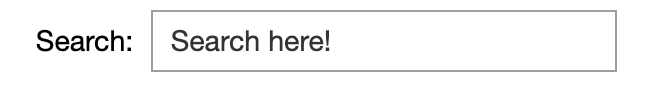

- The search field is attached with an event that gets triggered after entering some query into the field and pressing the ENTER key

- The event performs semantic search which uses our fine-tuned BERT embeddings to give response to the query that you enter.

### Pipeline

The following happens in sequence in the background when we press the ENTER key after adding some query in the search field,

1. Convert the search query into json format, {inputs:"Actual Search query"}
2. Synchronously call the Sagemaker hosting endpoint by passing the input as the above json. We created this endpoint under step Inference -> Realtime Endpoint
3. The Sagemaker endpoint takes the input (json converted) and passes it to the 'inference.py' script
4. The input query is pre-processed: Converting the query into BERT tokens
5. Pre-processed tokens are now passed to the BERT model function in the inference script and are transformed into 768 dimensional list
6. This list is then used to form the search query that OpenSearch will accept, 'bert_vector' term in the below query is the actual field name that we created in the index mapping step.
    
    {
      "query": {
        "knn": {
          "bert_vector": {
            "vector": "<List of 768 dimensions: Transformed vector of the query input>",
            "k": 1
          }
        }
      }
    }
    
7. The OpenSearch uses cosine similarity metric comparison between the query vector and the already indexed sentences in the OpenSearch domain and throws out the top k values sorted on similarity score in descending order.

successful run of the below code will create a search box.

In [ ]:
#Get the latest SageMaker Endpoint

runtime= boto3.client('sagemaker')
runtime.list_endpoints()['Endpoints']
endpoints = runtime.list_endpoints()
endpoints
latest_endpoint = sorted(endpoints['Endpoints'],key=lambda x: x['CreationTime'], reverse=True)[0]['EndpointName']

# Change k in production for the number of nearest neighbours

k_nearest = 2

from ipywidgets import interact, widgets
from IPython.display import display
import boto3
import json
from ast import literal_eval
lambda_client = boto3.client('lambda')
runtime= boto3.client('runtime.sagemaker')

#Build the HTML search widgets
text = widgets.Text(
    value='Search here!',
    placeholder='Search here!',
    description='Search:',
    disabled=False
)

text.style._view_name = '100px'

display(text)

def callback(wdgt):
    payload_ = json.dumps({"inputs": wdgt.value})
    res_ = runtime.invoke_endpoint(EndpointName=latest_endpoint,Body=payload_,ContentType='application/json')
    res = json.loads(res_['Body'].read().decode())['vectors'][0]
    q = 'miller'
    query = {"query":{
    "knn": {
      "bert_vector": {
        "vector": res,
        "k": k_nearest
      }
        }
    }}


    response = client.search(
    body = query,
    index = index_name
    )
    result = {}
    result['docs'] = []
    
    for i in response['hits']['hits']:
        if(len(result['docs']) == k_nearest):
            break
        dict_doc ={}
        dict_doc['doc'] = i['_source']['passage']
        dict_doc['score']=i['_score']
        result['docs'].append(dict_doc)
        
    
    display(result)

text.on_submit(callback)